<a href="https://colab.research.google.com/github/Muyikem21/Sunday_INFO5502_Spring2022/blob/main/INFO_5502_Final_Exam_Spring2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INFO 5502 Final Exam (05/12/2022, 240 points in total)

<span style='background:yellow'>**Question 3 (100 pt, each sub-question is 10 pt).**</span> 

Part A: Given Inetd dataset, an intrusion detection dataset that contains 2 columns. The first column represents a process ID number (PID) and the second column represents a system call. The goal is to extract the entire system call sequence by its PID, then tokenize and parse each sequence into 25-grams. After this, we’ll split the data into training and testing sets. Next, we ensure data quality in the training dataset by removing duplicate sequences within each class and overlapped sequences between both classes. To ensure a fair evaluation, we also clean the testing set by repeating the previous step. You will implement a Decision Tree model to train and test on the training set and testing set that we just clean. 


Part B: As the data type is sequential, we want to know how similar the sequences from both classes are and visualize how the similarity scores vary in different sequence lengths. Compute a cosine similarity score of 100 random pairs from both classes and get a median cosine similarity. Repeat this step in different sequence lengths (5, 10, 15, and 20). Plot a line chart to visualize how the median cosine similarities vary through sequence lengths of 5 to 25. 

You can download the datasets from github: https://github.com/unt-iialab/info5502-spring2022/tree/main/finalexam/q4


Step by step instructions and questions:

(1) Attached are the Normal and Intrusion data folders. Read in the data and store them in two separate dataframes. Combine the system calls (the second column) from the same PID (the first column) into a sequence or a string. 

(2) Parse an entire sequence into smaller sequences of size 25. (Hint: Use word_tokenize and ngrams from nltk library to parse).

(3) Add labels to the data, and partition the labeled data into training data and testing data with a ratio of 70/30.

(4) As the dataset has a lot of duplicate sequences, make sure that the testing data only contain unique sequences and that these sequences do not exist in the training data. Condense training data and testing data into two sets. Take the difference between the testing set and training set to remove the overlapped sequences from the testing data. 

(5) The sequences from each class can be repetitive, and some of these sequences may have different labels. Therefore, we need to remove the duplicate sequences within each class and the overlapped sequences from the Intrusion class. Start out by separating the Normal class and Intrusion class in the training data. Use the same concept in Question 4 to remove duplicate sequences and overlapped sequences from the training data.

(6) Repeat Question 5 to clean the testing data.

(7) Bootstrap the training data to get the same number of sequences from each class. Train and evaluate a Decision Tree model using the training data and testing data that we just clean. How is the performance?

(8) Randomly sample 100 pairs of sequences from both classes and calculate the median cosine similarity.

(9) Refer back to Question 2, parse the data into a length of 5, 10, 15, and 20. Clean the data from each class using Question 5. For each sequence length, calculate the median cosine similarity of 100 random pairs of sequences from both classes. 

(10) Plot a line chart to visualize how the median cosine similarities vary through different sequence lengths from 5 to 25.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
intd_intrusion = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-intrusion.int", sep = " ", header = None)
intd_normal = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-normal.int", sep = " ", header = None)

intd_intrusion.columns = ['PID', 'SystemCalls']
intd_intrusion.head(2)



,PID,SystemCalls
0,167,90
1,167,125


In [14]:
intd_normal.columns = ['PID', 'SystemCalls']
intd_normal.head(2)


,PID,SystemCalls
0,167,90
1,167,125


In [15]:
#The description of the data
intd_intrusion.describe()


,PID,SystemCalls
count,8371.000000,8371.000000
mean,4093.249074,13.621192
std,1154.934136,25.679120
min,167.000000,1.000000
25%,4447.000000,6.000000
50%,4455.000000,6.000000
75%,4463.000000,6.000000
max,4470.000000,136.000000


In [16]:
intd_normal.describe()

,PID,SystemCalls
count,541.000000,541.000000
mean,1397.634011,40.417745
std,1251.546012,46.519004
min,167.000000,1.000000
25%,168.000000,6.000000
50%,168.000000,6.000000
75%,2669.000000,91.000000
max,2669.000000,136.000000


It is evident from the results that all the parameters in the intrusion, both the PID and Systemscalls are larger than that of normal. They both have the minimum value as 167.

In [18]:
# We want to know the shape of the data.
intd_intrusion.shape

(8371, 2)

Intrusion has 8,371 rows and 2 columns

In [19]:
intd_normal.shape

(541, 2)

Normal has 541 rows and 2 columns.
One can now understand why the parameters of intrusion are larger in values than that of normal. The number of rows in intrusion is 15 times of the rows in normal.

In [20]:
#We want to check if there is any missing value.
print(intd_normal.any().isna())
print('No null values \n')
print(intd_intrusion.any().isna())
print('No null values')

PID            False
SystemCalls    False
dtype: bool
No null values 

PID            False
SystemCalls    False
dtype: bool
No null values


The above results show that there is no missing values in both intrusion and normal dataset.

In [21]:
#Here, we are creating two dictionaries
dict_intd_intrusion = {}
dict_intd_normal = {}

#Systems calls are brought together.
for pid in list(set(intd_intrusion['PID'].values)):
    dict_intd_intrusion[pid] = " ".join(str(value) for value in list(intd_intrusion[intd_intrusion['PID'] == pid]['SystemCalls'].values))

for pid in list(set(intd_normal['PID'].values)):
    dict_intd_normal[pid] = " ".join(str(value) for value in list(intd_normal[intd_normal['PID'] == pid]['SystemCalls'].values))

dict_intd_intrusion[167]

'90 125 125 106 5 90 6 5 3 90 90 90 90 6 125 91 125 125 125 136 49 24 47 50 45 45 5 106 106 106 106 106 2 1'

In [22]:
#Libraries needed are imported.
import re
from nltk.util import ngrams
list_intrusion = []
list_normal = []

#Here, we want to generate ngrams with sequence length of 25
for key in dict_intd_intrusion.keys():
    s = dict_intd_intrusion[key]
    tokens = [token for token in s.split(" ") if token != ""]
    
    for ele in list(ngrams(tokens, 25)):
        list_intrusion.append(ele)
        
for key in dict_intd_normal.keys():
    s = dict_intd_normal[key]
    tokens = [token for token in s.split(" ") if token != ""]
    
    for ele in list(ngrams(tokens, 25)):
        list_normal.append(ele) 
print(len(list_intrusion))
print(len(list_normal))

7627
469


In [24]:
#The data are transformed into dataframes
intd_intrusion1 = pd.DataFrame(list_intrusion)
intd_normal1 = pd.DataFrame(list_normal)

# adding labels to intrusion and normal data sequences
intd_intrusion['class'] = 1
intd_normal['class'] = 0

intd_intrusion1.shape


(7627, 25)

In [25]:
intd_normal1.shape

(469, 25)

In [26]:
combined_data = pd.DataFrame()

combined_data = combined_data.append(intd_intrusion1)
combined_data = combined_data.append(intd_normal1)

combined_data.shape

(8096, 25)

In [27]:
combined_data = combined_data.drop_duplicates(subset = combined_data.columns[:-1], keep = 'last')
combined_data.shape

(322, 25)

In [29]:
combined_data.columns[:-1]

RangeIndex(start=0, stop=24, step=1)

(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)

In [38]:
#Build a decision tree, we would import the appropriate libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x = combined_data.drop("class", axis = 1)
y = combined_data["class"]
#Spiltting the data into 70/30 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 5)
#Defining the Decision Tree
DT = DecisionTreeClassifier(max_depth = 10)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
#Printing the Report
print(classification_report(y_test, y_pred))

#Obtaining the ngram
import re
from nltk.util import ngrams
import pandas as pd

cosine_similar_ngram = {}

for ngram in range(5, 26, 5):

 intd_intrusion = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-intrusion.int", sep = " ", header = None)
intd_normal = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/finalexam/q4/inetd-normal.int", sep = " ", header = None)

intd_intrusion.columns = ['PID', 'SystemCalls']
intd_normal.columns = ['PID', 'SystemCalls']

dict_intd_intrusion = {}
dict_intd_normal_ = {}
for pid in list(set(intd_intrusion['PID'].values)):
        dict_intd_intrusion[pid] = " ".join(str(value) for value in list(intd_intrusion[intd_intrusion['PID'] == pid]['SystemCalls'].values))
for pid in list(set(intd_normal['PID'].values)):
        dict_intd_normal[pid] = " ".join(str(value) for value in list(intd_normal[intd_normal['PID'] == pid]['SystemCalls'].values))
list_intrusion = []
list_normal = []
for key in dict_intd_intrusion.keys():
 s = dict_intd_intrusion[key]
tokens = [token for token in s.split(" ") if token != ""]
for ele in list(ngrams(tokens, ngram)):
         list_intrusion.append(ele)
for key in dict_intd_normal.keys():
        s = dict_intd_normal[key]
        tokens = [token for token in s.split(" ") if token != ""]
for ele in list(ngrams(tokens, ngram)):
         list_normal.append(ele)
intd_intrusion1 = pd.DataFrame(list_intrusion)
intd_normal1 = pd.DataFrame(list_normal)
intd_intrusion1['class'] = 1
intd_normal1['class'] = 0
combined_data = pd.DataFrame()
combined_data = combined_data.append(intd_intrusion1)
combined_data = combined_data.append(intd_normal1)
combined_data.shape
print()
combined_data = combined_data.drop_duplicates(subset = combined_data.columns[:-1], keep = 'last')
combined_data.shape
print()
from sklearn.metrics.pairwise import cosine_similarity
import statistics
similarities_list = []
for i in range(0, 100):
    list1 = list(combined_data[combined_data['class'] == 0].sample(n = 1).iloc[0, :].values)
    list2 = list(combined_data[combined_data['class'] == 1].sample(n = 1).iloc[0, :].values)
    try:
        similarities_list.append(cosine_similarity([list1], [list2]))
    except Exception as e:
          print(e)
    print(list1, list2)
    print(statistics.median(similarities_list)[0][0])
    print()
    cosine_similar_ngram[ngram] = statistics.median(similarities_list)[0][0]


              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.75      1.00      0.86         3

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8



['90', '6', '5', '3', '90', '90', '90', '90', '6', '125', '91', '125', '125', '125', '136', '49', '24', '47', '50', '45', '45', '5', '106', '106', '106', 0] ['45', '108', '90', '3', '19', '6', '91', '63', '6', '63', '63', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', 1]
0.47805838476181833

['5', '3', '90', '90', '90', '90', '6', '125', '91', '125', '125', '125', '136', '49', '24', '47', '50', '45', '45', '5', '106', '106', '106', '106', '106', 0] ['108', '90', '3', '19', '6', '91', '63', '6', '63', '63', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', 1]
0.4282175144344593

['5', '90', '6', '5', '3', '90', '90',

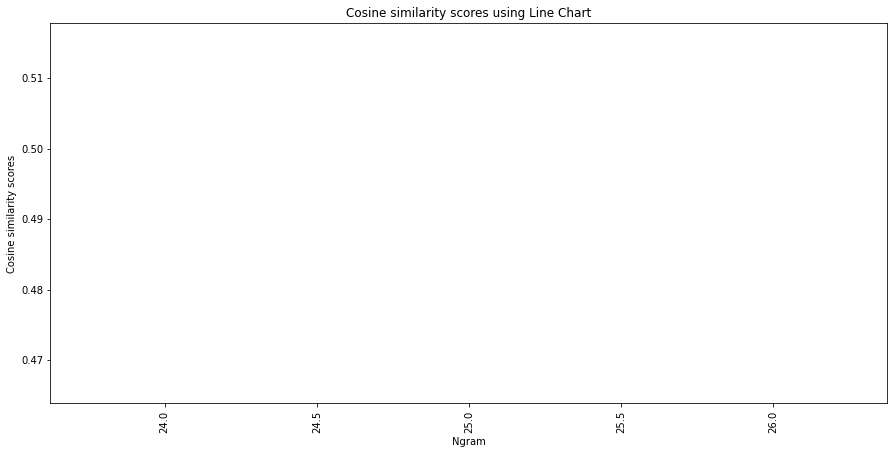

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

cosine_similar_ngram_df = pd.DataFrame({"Ngram":list(cosine_similar_ngram.keys()), "Similarity_scores": list(cosine_similar_ngram.values())})


plt.rcParams['figure.figsize'] = [15, 7]

sns.lineplot(x = "Ngram", y = "Similarity_scores", data = cosine_similar_ngram_df)
    
plt.title("Cosine similarity scores using Line Chart")
plt.xlabel("Ngram")
plt.ylabel("Cosine similarity scores")
plt.xticks(rotation = 90)
plt.show()

[Text(0.5, 0.75, 'X[9] <= 76.5\ngini = 0.415\nsamples = 17\nvalue = [5, 12]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]')]

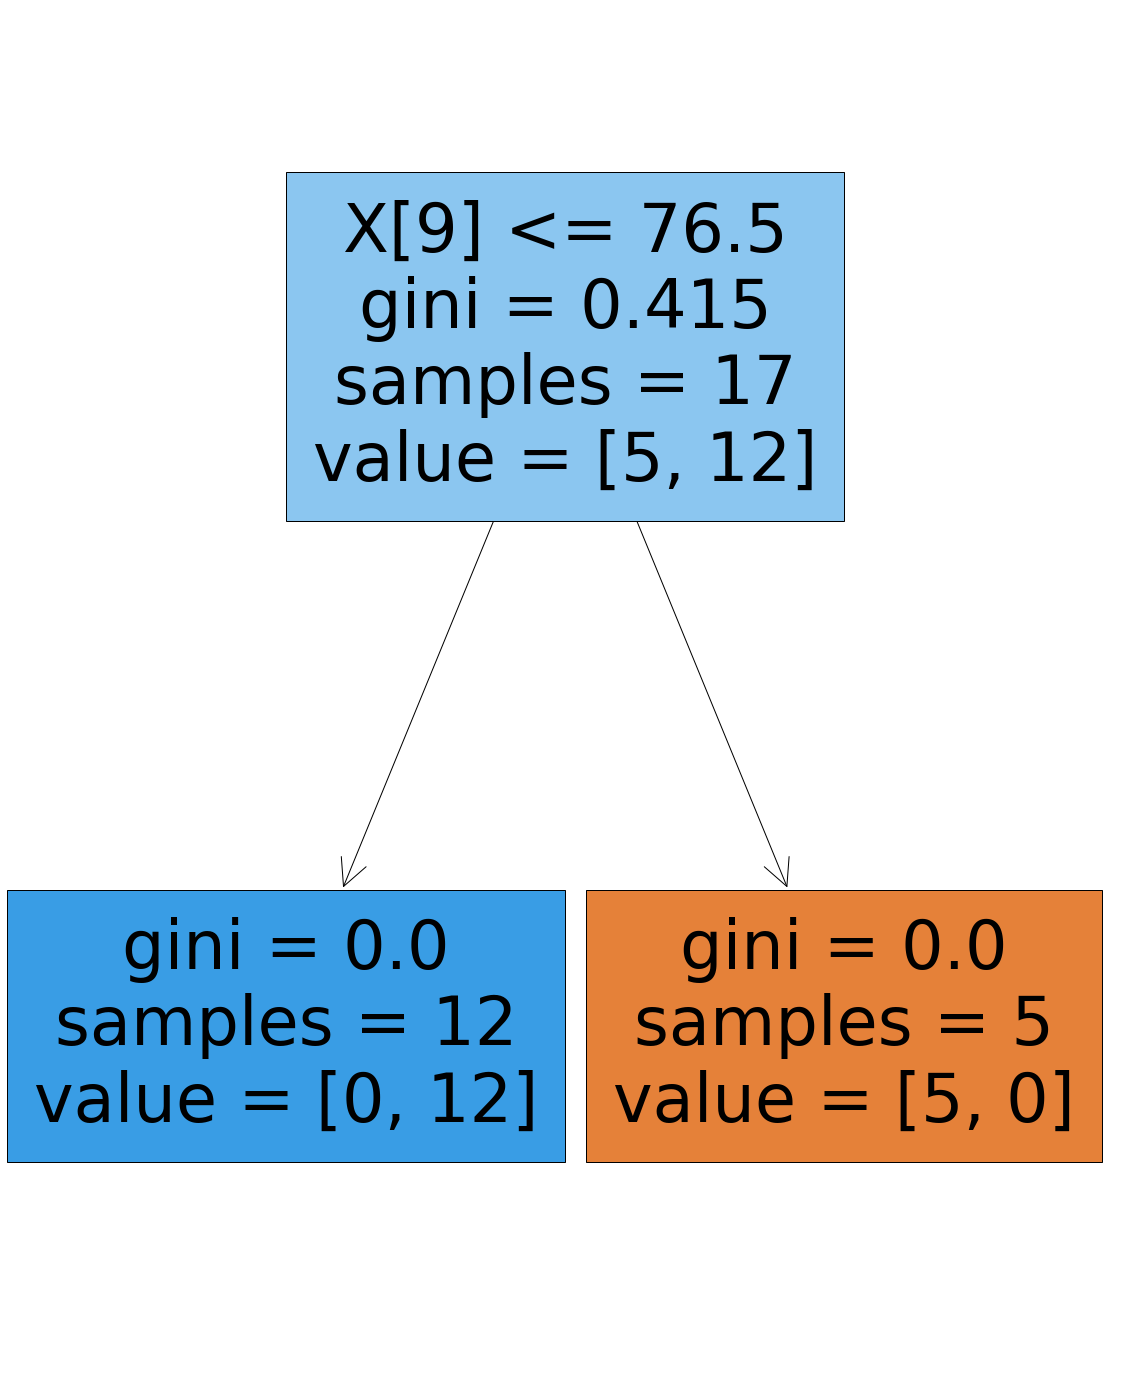

In [40]:
from sklearn import tree
plt.figure(figsize=(20,25))
tree.plot_tree(DT,filled=True)